# Tutorial \#3: Blach Hole and Accretion Disk Parameters

**Nicolás Guerra-Varas**
Professor Dragana Ilić
Tutor Isidora Jankov

Date: 

Data: sample of 500 SDSS quasars (QSOs) with spectral parameters from __[Shen et al. 2011
](https://ui.adsabs.harvard.edu/abs/2011ApJS..194...45S/abstract)__ (__[VizieR catalog](https://vizier.cds.unistra.fr/viz-bin/VizieR?-source=J/ApJS/194/45)__).

The goal of this tutorial is to learn how to estimate the mass of the black hole (BH) of active galactic nuclei (AGN) with indirect methods: scaling relationships from reverberation mapping (RM) and the use of the bulge luminosity of the host galaxy.

---

## Preparing data

In [44]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('bmh')

import seaborn as sns
sns.set_theme()
sns.set_context('paper')

from collections import Counter

In [22]:
qsos = pd.read_csv('shen_subsample_500.csv')
qsos.reset_index(inplace=True, drop=True)
qsos

,RAJ2000,DEJ2000,Plate,Fiber,MJD,iMAG,logLbol,e_logLbol,logLBHb,e_logLBHb,W_BHb_,e_W_BHb_,EWBHb,e_EWBHb,SN_Hb_,logBH,e_logBH,logEdd
0,189.67804,45.30687,1372,486,53062,-23.20,45.236,0.004,42.35,0.02,4399.3,330.1,62.0,3.1,23.06,8.33,0.07,-1.20
1,189.77188,41.44564,1984,609,53433,-22.29,44.819,0.005,42.11,0.04,2371.4,541.6,89.4,8.7,15.06,7.59,0.20,-0.87
2,189.81419,53.23740,885,449,52379,-22.69,45.121,0.004,41.93,0.04,10756.6,4366.4,32.1,3.4,16.27,9.05,0.35,-2.03
3,189.93733,19.90707,2614,350,54481,-23.37,45.132,0.001,42.55,0.02,15241.3,362.8,118.7,6.3,19.79,9.36,0.02,-2.33
4,189.99405,49.09448,1278,96,52735,-22.77,45.166,0.011,42.25,0.01,1385.6,48.6,52.5,2.9,15.96,7.29,0.03,-0.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,231.08040,27.95578,1846,28,54173,-23.33,45.423,0.005,42.56,0.02,9345.2,348.3,60.6,3.4,24.76,9.08,0.03,-1.76
496,231.09229,26.70657,2160,444,53885,-22.72,44.989,0.005,42.19,0.04,4363.7,503.4,73.2,6.8,17.34,8.20,0.10,-1.31
497,231.11946,30.54376,1650,545,53174,-24.56,45.891,0.001,43.14,0.01,2572.5,106.9,76.1,1.9,40.15,8.19,0.04,-0.40
498,231.12225,35.25613,1354,466,52814,-22.60,45.143,0.005,41.80,0.05,1559.7,243.2,21.0,2.7,15.44,7.38,0.14,-0.34


In [23]:
qsos.columns

Index(['RAJ2000', 'DEJ2000', 'Plate', 'Fiber', 'MJD', 'iMAG', 'logLbol',
       'e_logLbol', 'logLBHb', 'e_logLBHb', 'W_BHb_', 'e_W_BHb_', 'EWBHb',
       'e_EWBHb', 'SN_Hb_', 'logBH', 'e_logBH', 'logEdd'],
      dtype='object')

In [24]:
qsos.shape

(500, 18)

## Scaling relations from RM

First, I got a `.txt` file with plate, mjd and fiber ID for SDSS cross-match

In [25]:
cross_id = qsos[['Plate', 'MJD', 'Fiber']]
cross_id

,Plate,MJD,Fiber
0,1372,53062,486
1,1984,53433,609
2,885,52379,449
3,2614,54481,350
4,1278,52735,96
...,...,...,...
495,1846,54173,28
496,2160,53885,444
497,1650,53174,545
498,1354,52814,466


In [26]:
qsos.shape

(500, 18)

In [27]:
cross_id.shape

(500, 3)

In [28]:
Counter(cross_id.duplicated())

Counter({False: 500})

In [29]:
# cross_id_str = cross_id.to_string(index=False, header=False)
# cross_id_file = open('cross_id_input.txt', 'a')
# cross_id_file.write(cross_id_str)
# cross_id_file.close()

I used the `cross_id_input.txt` file to cross match the sample with SDSS in the __[CrossMatch Tool](https://skyserver.sdss.org/dr18/CrossMatchTools/ObjectCrossID)__. The SQL query I used is:

```
SELECT s.z AS redshift, g.h_beta_flux, s.ra, s.dec, s.plate, s.mjd, s.fiberID
FROM #upload u
      JOIN SpecObjAll as s
      ON (s.plate=u.up_plate AND s.mjd=u.up_mjd AND s.fiberID=u.up_fiber)
      JOIN
      GalSpecLine AS g
      ON g.specobjid = s.specobjid
```

The result is in the `crosmatch_shen_subsample.csv` file.

In [30]:
sdss_qsos = pd.read_csv('crosmatch_shen_subsample.csv', skiprows=1)
sdss_qsos

,redshift,h_beta_flux,ra,dec,plate,mjd,fiberID
0,0.183985,300.96690,195.03333,3.932381,849,52439,300
1,0.252761,391.48320,217.41974,3.357194,585,52027,214
2,0.268422,410.67200,219.91783,3.091284,586,52023,89
3,0.192150,199.62830,201.07607,58.819914,959,52411,192
4,0.171041,153.48380,203.15810,59.514940,960,52425,321
...,...,...,...,...,...,...,...
495,0.250829,15.71955,200.50446,51.710448,1667,53430,543
496,0.258147,525.93010,221.39478,46.643204,1675,53466,428
497,0.227546,210.10160,205.87458,28.055933,2017,53474,180
498,0.211458,172.48770,205.95884,28.034967,2017,53474,168


In [12]:
sdss_qsos.columns

Index(['redshift', 'h_beta_flux', 'ra', 'dec', 'plate', 'mjd', 'fiberID'], dtype='object')

In [31]:
sdss_qsos.shape

(500, 7)

In [34]:
qsos.shape

(500, 18)

In [38]:
# I joined the dfs so it's easier to manipulate
qsos = pd.concat([qsos, sdss_qsos], axis=1)
qsos

,RAJ2000,DEJ2000,Plate,Fiber,MJD,iMAG,logLbol,e_logLbol,logLBHb,e_logLBHb,...,logBH,e_logBH,logEdd,redshift,h_beta_flux,ra,dec,plate,mjd,fiberID
0,189.67804,45.30687,1372,486,53062,-23.20,45.236,0.004,42.35,0.02,...,8.33,0.07,-1.20,0.183985,300.96690,195.03333,3.932381,849,52439,300
1,189.77188,41.44564,1984,609,53433,-22.29,44.819,0.005,42.11,0.04,...,7.59,0.20,-0.87,0.252761,391.48320,217.41974,3.357194,585,52027,214
2,189.81419,53.23740,885,449,52379,-22.69,45.121,0.004,41.93,0.04,...,9.05,0.35,-2.03,0.268422,410.67200,219.91783,3.091284,586,52023,89
3,189.93733,19.90707,2614,350,54481,-23.37,45.132,0.001,42.55,0.02,...,9.36,0.02,-2.33,0.192150,199.62830,201.07607,58.819914,959,52411,192
4,189.99405,49.09448,1278,96,52735,-22.77,45.166,0.011,42.25,0.01,...,7.29,0.03,-0.23,0.171041,153.48380,203.15810,59.514940,960,52425,321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,231.08040,27.95578,1846,28,54173,-23.33,45.423,0.005,42.56,0.02,...,9.08,0.03,-1.76,0.250829,15.71955,200.50446,51.710448,1667,53430,543
496,231.09229,26.70657,2160,444,53885,-22.72,44.989,0.005,42.19,0.04,...,8.20,0.10,-1.31,0.258147,525.93010,221.39478,46.643204,1675,53466,428
497,231.11946,30.54376,1650,545,53174,-24.56,45.891,0.001,43.14,0.01,...,8.19,0.04,-0.40,0.227546,210.10160,205.87458,28.055933,2017,53474,180
498,231.12225,35.25613,1354,466,52814,-22.60,45.143,0.005,41.80,0.05,...,7.38,0.14,-0.34,0.211458,172.48770,205.95884,28.034967,2017,53474,168


In [39]:
qsos.shape

(500, 25)

In [40]:
qsos.columns

Index(['RAJ2000', 'DEJ2000', 'Plate', 'Fiber', 'MJD', 'iMAG', 'logLbol',
       'e_logLbol', 'logLBHb', 'e_logLBHb', 'W_BHb_', 'e_W_BHb_', 'EWBHb',
       'e_EWBHb', 'SN_Hb_', 'logBH', 'e_logBH', 'logEdd', 'redshift',
       'h_beta_flux', 'ra', 'dec', 'plate', 'mjd', 'fiberID'],
      dtype='object')

There were no lost objects. In this step, I realised that the text file used for the SDSS SQL query needs a header, as it never processes the first line of text.

### Exploratory Plots

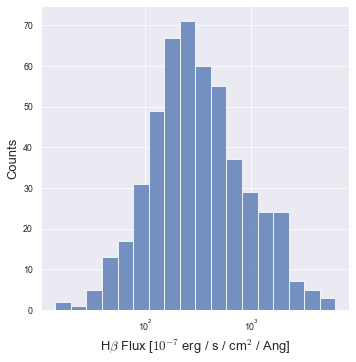

In [47]:
sns.displot(data=qsos, x='h_beta_flux', palette='colorblind', log_scale=True)

plt.ylabel('Counts', fontsize=13);
plt.xlabel(r'H$\beta$ Flux [$10^{-7}$ erg / s / cm$^2$ / Ang]', fontsize=13);

# plt.savefig('qsos_Hbeta_distr.pdf')

plt.show()

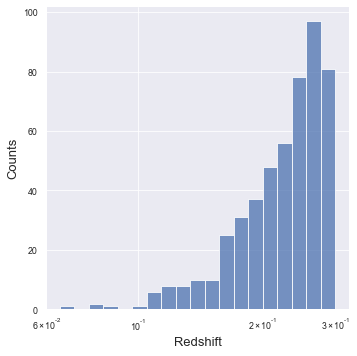

In [50]:
sns.displot(data=qsos, x='redshift', palette='colorblind', log_scale=True)

plt.ylabel('Counts', fontsize=13);
plt.xlabel('Redshift', fontsize=13);

# plt.savefig('qsos_z_distr.pdf')

plt.show()

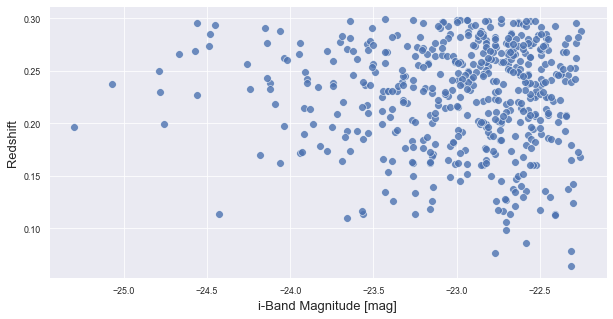

In [78]:
f, ax = plt.subplots(figsize=(10, 5))

sns.scatterplot(data=qsos, x='iMAG', y='redshift', palette='colorblind', s=60, alpha=0.8)

plt.xlabel(r'i-Band Magnitude [mag]', fontsize=13);
plt.ylabel('Redshift', fontsize=13);

# plt.savefig('qsos_imag_vs_z.pdf')

plt.show()

#### FWHM

To calculate the Full Width Half Maximum (FWHM) of the lines, I went back to the SDSS Cross-Match tool to download the velocity dispersions $\sigma$ of the lines. The FWHM can be calculated with:
\begin{align}
      \text{FWHM} = 2 \sqrt{ 2 \ln{2} } \times \sigma \approx 2.355 \times \sigma
\end{align}

This is the SQL query I used:

```
SELECT s.plate, s.mjd, s.fiberID, g.sigma_balmer, g.sigma_forbidden
FROM #upload u
      JOIN SpecObjAll s
      ON (s.plate=u.up_plate AND s.mjd=u.up_mjd AND s.fiberID=u.up_fiber)
      JOIN GalSpecLine AS g
      ON g.specobjid = s.specobjid
```

In addition to the Balmer series lines, I also downloaded the velocity dispersion for the forbidden lines just in case it comes in handy. The result of this query is in `vel_dispersions.csv`.

---

The most efficient SQL query that downloads all needed information would have been:
```
SELECT s.z AS redshift, g.h_beta_flux, g.sigma_balmer, g.sigma_forbidden
FROM #upload u
      JOIN SpecObjAll as s
      ON (s.plate=u.up_plate AND s.mjd=u.up_mjd AND s.fiberID=u.up_fiber)
      JOIN
      GalSpecLine AS g
      ON g.specobjid = s.specobjid
```

In [84]:
sigmas = pd.read_csv('vel_dispersions.csv', header=1)
sigmas.drop_duplicates(inplace=True)  # there are two identical rows per object
sigmas

,plate,mjd,fiberID,sigma_balmer,sigma_forbidden
0,1045,52725,72,313.062,291.7598
1,1050,52721,500,500.000,245.1475
2,1344,52792,91,500.000,282.8331
3,1346,52822,86,500.000,500.0000
4,1378,53061,574,500.000,206.1464
...,...,...,...,...,...
982,2115,53535,265,500.000,500.0000
983,2160,53885,243,500.000,500.0000
984,2770,54510,433,500.000,500.0000
985,2771,54527,71,500.000,253.8604


Use astropy.cosmology for luminosity

## Bulge Luminosity of the Host Galaxy